In [4]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet
import seaborn as sns
from matplotlib.dates import DateFormatter
from numpy import polyfit
from scipy import signal, stats
from sklearn.datasets import fetch_openml
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
pollution = pd.read_csv(
    "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/"
    "Air%20pollution%20by%20city%20-%20Fouquet%20and%20DPCC%20(2011)/Air%20pollution%20by%20city%20-%20Fouquet%20and%20DPCC%20(2011).csv"
)
len(pollution)

331

In [6]:
pollution.columns

Index(['Entity', 'Year', 'Smoke (Fouquet and DPCC (2011))',
       'Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))'],
      dtype='object')

In [7]:
pollution = pollution.rename(
    columns={
        "Suspended Particulate Matter (SPM) (Fouquet and DPCC (2011))": "SPM",
        "Smoke (Fouquet and DPCC (2011))": "Smoke",
        "Entity": "City",
    }
)
pollution.dtypes

City      object
Year       int64
Smoke    float64
SPM      float64
dtype: object

In [8]:
pollution.City.unique()

array(['Delhi', 'London'], dtype=object)

In [9]:
pollution.Year.min(), pollution.Year.max()

(1700, 2016)

In [10]:
pollution["Year"] = pollution["Year"].apply(
    lambda x: datetime.datetime.strptime(str(x), "%Y")
)
pollution.dtypes

City             object
Year     datetime64[ns]
Smoke           float64
SPM             float64
dtype: object

In [11]:
pollution.isnull().mean()

City     0.000000
Year     0.000000
Smoke    0.090634
SPM      0.000000
dtype: float64

In [12]:
pollution.describe()

,Smoke,SPM
count,301.000000,331.000000
mean,210.296440,365.970050
std,88.543288,172.512674
min,13.750000,15.000000
25%,168.571429,288.474026
50%,208.214286,375.324675
75%,291.818182,512.609209
max,342.857143,623.376623


Text(0, 0.5, 'Frequency')

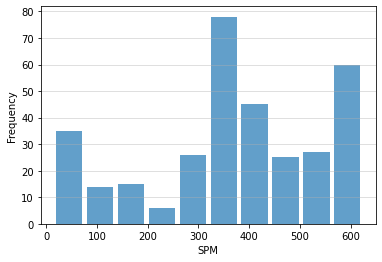

In [13]:
plt.grid(axis="y", alpha=0.5)
n, bins, patches = plt.hist(x=pollution["SPM"], bins="auto", alpha=0.7, rwidth=0.85)

plt.xlabel("SPM")
plt.ylabel("Frequency")

In [14]:
def ignore_nans(a, b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]


stats.pearsonr(*ignore_nans(pollution["Smoke"], pollution["SPM"]))

PearsonRResult(statistic=0.9999999999999999, pvalue=0.0)

Text(333.4714285714286, 0.5, 'SPM')

<Figure size 864x432 with 0 Axes>

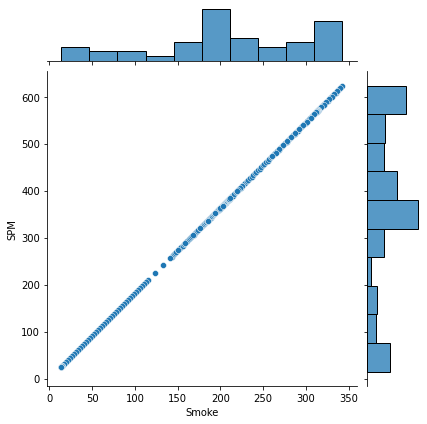

In [15]:
plt.figure(figsize=(12, 6))
sns.jointplot(x="Smoke", y="SPM", edgecolor="white", data=pollution)
plt.xlabel("Smoke")
plt.ylabel("SPM")

Text(0, 0.5, 'SPM')

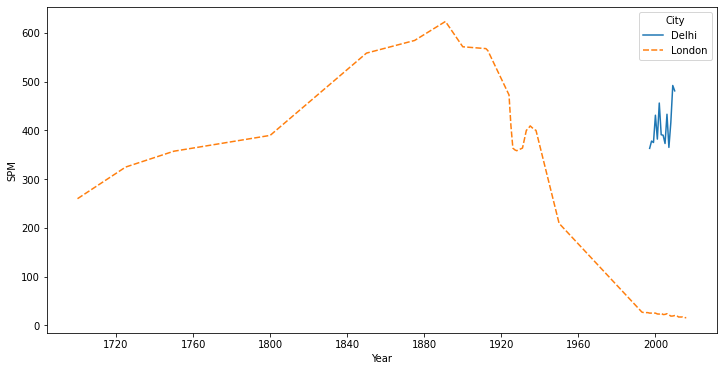

In [16]:
pollution = pollution.pivot("Year", "City", "SPM")
plt.figure(figsize=(12, 6))
sns.lineplot(data=pollution)
plt.ylabel("SPM")

In [17]:
temperatures = pd.read_csv("data/monthly.csv")
temperatures["Date"] = pd.to_datetime(temperatures["Date"])
temperatures = temperatures.pivot("Date", "Source", "Mean")
temperatures = temperatures.resample("M").first()

In [18]:
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)


def get_season(s, yearly_periods=4, degree=3):
    X = [i % (365 / 4) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)


def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

19:11:16 - cmdstanpy - INFO - Chain [1] start processing
19:11:17 - cmdstanpy - INFO - Chain [1] done processing


Text(0, 0.5, 'Temperature change')

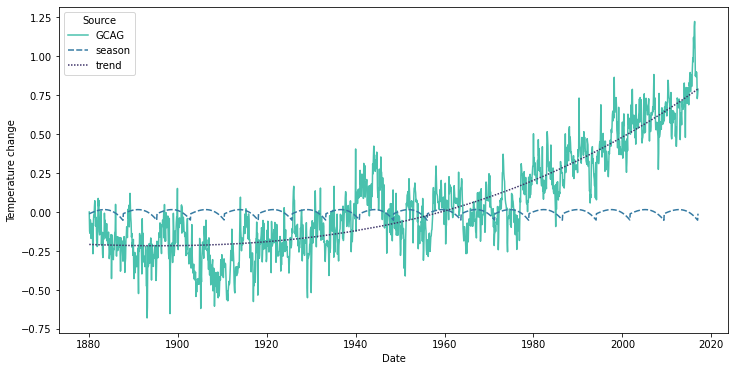

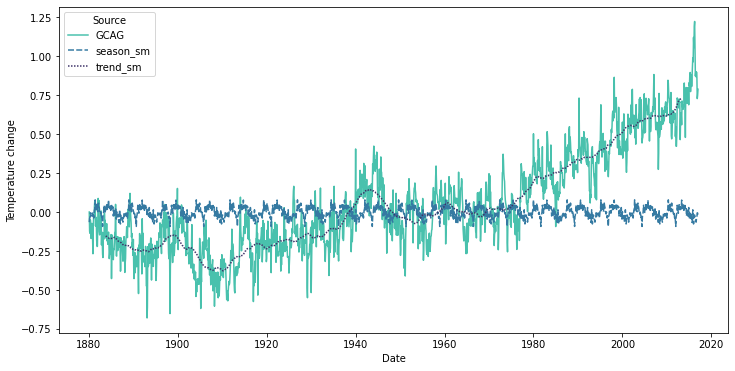

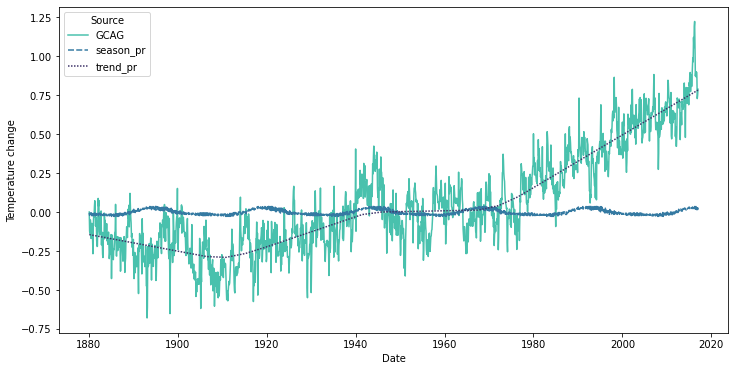

In [19]:
# Trends with polyfit
plt.figure(figsize=(12, 6))
temperatures["trend"] = get_trend(temperatures["GCAG"])
temperatures["season"] = get_season(temperatures["GCAG"] - temperatures["trend"])
sns.lineplot(
    data=temperatures[["GCAG", "season", "trend"]],
    palette=sns.color_palette("mako_r", 3),
)
plt.ylabel("Temperature change")

# Trends with statsmodels seasonal_decompose
sd = seasonal_decompose(
    temperatures[["GCAG"]], model="additive", period=int(365.25 / 4)
)
plt.figure(figsize=(12, 6))
temperatures["trend_sm"] = sd.trend.dropna()
temperatures["season_sm"] = sd.seasonal.dropna()
sns.lineplot(
    data=temperatures[["GCAG", "season_sm", "trend_sm"]],
    palette=sns.color_palette("mako_r", 3),
)
plt.ylabel("Temperature change")

# Trends with prophet
df = temperatures[["GCAG"]].reset_index()
df.columns = ["ds", "y"]
model = prophet.Prophet()
model.add_seasonality("quarter", period=int(365.25 / 4), fourier_order=8)
model.fit(df)
forecast = model.predict(df)
plt.figure(figsize=(12, 6))
temperatures.loc[:, "trend_pr"] = forecast["trend"].values
temperatures.loc[:, "season_pr"] = forecast["quarter"].values
sns.lineplot(
    data=temperatures[["GCAG", "season_pr", "trend_pr"]],
    palette=sns.color_palette("mako_r", 3),
)
plt.ylabel("Temperature change")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

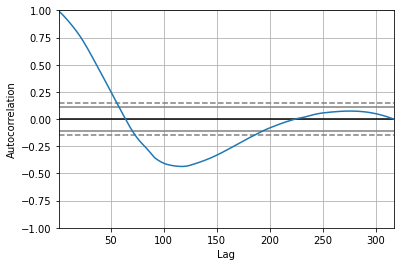

In [20]:
pd.plotting.autocorrelation_plot(pollution["London"])

In [21]:
stattools.adfuller(pollution["London"])

(-0.33721640804242636,
 0.9200654843183901,
 13,
 303,
 {'1%': -3.4521175397304784,
  '5%': -2.8711265007266666,
  '10%': -2.571877823851692},
 1684.699266349387)

In [22]:
eeg = fetch_openml(data_id=1471, as_frame=True)
increment = 117 / len(eeg["data"])
index = np.linspace(start=0, stop=increment * len(eeg["data"]), num=len(eeg["data"]))
ts_index = pd.to_datetime(index, unit="s")
v1 = pd.Series(name="V1", data=eeg["data"]["V1"].values, index=ts_index)

In [23]:
slicing = (v1.index >= "1970-01-01 00:00:08") & (
    v1.index <= "1970-01-01 00:01:10.000000000"
)
v1[slicing]

1970-01-01 00:00:08.006208692    4289.74
1970-01-01 00:00:08.014019627    4284.10
1970-01-01 00:00:08.021830562    4280.00
1970-01-01 00:00:08.029641498    4289.74
1970-01-01 00:00:08.037452433    4298.46
                                  ...   
1970-01-01 00:01:09.962547566    4289.74
1970-01-01 00:01:09.970358501    4283.08
1970-01-01 00:01:09.978169437    4284.62
1970-01-01 00:01:09.985980372    4289.23
1970-01-01 00:01:09.993791307    4290.77
Name: V1, Length: 7937, dtype: float64

Text(0, 0.5, 'voltage')

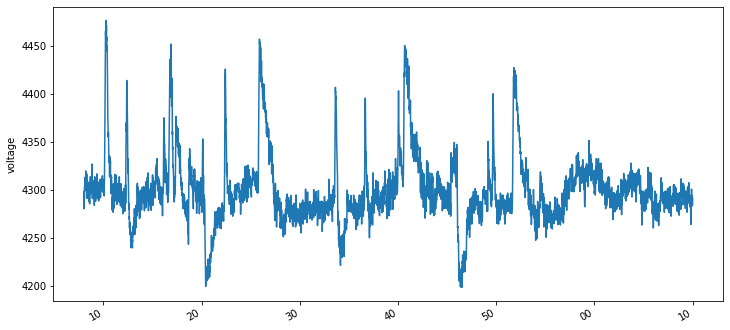

In [24]:
date_formatter = DateFormatter("%S")
ax = v1[slicing].plot(figsize=(12, 6))
ax.xaxis.set_major_formatter(date_formatter)
plt.ylabel("voltage")

Text(0.5, 0, 'seconds')

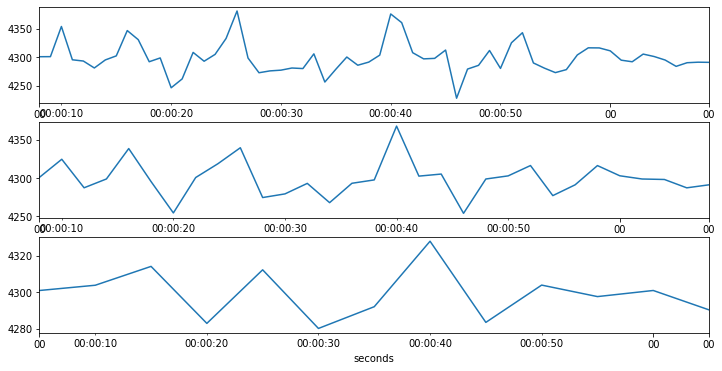

In [25]:
plt.subplot(311)
ax1 = v1[slicing].resample("1s").mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(312)
ax1 = v1[slicing].resample("2s").mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(313)
ax2 = v1[slicing].resample("5s").mean().plot(figsize=(12, 6))
ax2.xaxis.set_major_formatter(date_formatter)
plt.xlabel("seconds")

Text(0, 0.5, 'PSD [V**2/Hz]')

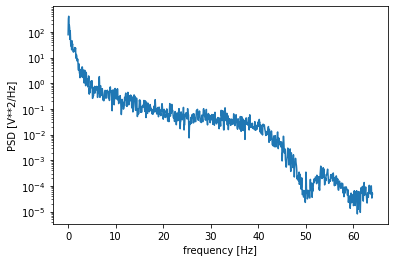

In [26]:
fs = len(eeg["data"]) // 117
f, Pxx_den = signal.welch(v1[slicing].values, fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx_den)
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")